### Binary Classification
The target variable is CANCELLED. The main problem here is going to be huge class imbalance. We have only very little cancelled flights with comparison to all flights. It is important to do the right sampling before training and to choose correct evaluation metrics.

In [1]:
import pandas as pd
import numpy as np
import psycopg2
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from ma_functions import *
import datetime
from sklearn import preprocessing
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from collections import Counter

In [2]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import collections

from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from imblearn.pipeline import make_pipeline as imbalanced_make_pipeline
from imblearn.over_sampling import SMOTE
from imblearn.metrics import classification_report_imbalanced
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report
from collections import Counter
from sklearn.model_selection import KFold, StratifiedKFold


In [4]:
con = psycopg2.connect(database="mid_term_project", user="lhl_student", password="lhl_student", host="mid-term-project.ca2jkepgjpne.us-east-2.rds.amazonaws.com", port="5432")

print("Database opened successfully")

def sql_execute(sql,con):
    cur = con.cursor()
    cur.execute(sql)
    print("Table created successfully")
    con.commit()
    con.close()

def sql_read(sql,con):
    return pd.read_sql(sql,con)

Database opened successfully


# Retrieve Data

In [5]:
query='''
SELECT fl_date,
dep_time,
op_unique_carrier,
origin_airport_id,
dest_airport_id,
taxi_out,
arr_delay,
taxi_in,
distance,
air_time,
crs_elapsed_time,
origin_city_name,
dest_city_name,
crs_dep_time,
crs_arr_time,
dep_delay,
carrier_delay,
weather_delay,
nas_delay,
security_delay,
late_aircraft_delay,
cancelled
FROM flights
LIMIT 10000
'''
X_cancel=sql_read(query,con)
X_cancel.head(10)

,fl_date,dep_time,op_unique_carrier,origin_airport_id,dest_airport_id,taxi_out,arr_delay,taxi_in,distance,air_time,...,dest_city_name,crs_dep_time,crs_arr_time,dep_delay,carrier_delay,weather_delay,nas_delay,security_delay,late_aircraft_delay,cancelled
0,2019-06-07,848.0,WN,13232,10140,10.0,-33.0,4.0,1121.0,145.0,...,"Albuquerque, NM",850,1100,-2.0,NaN,NaN,NaN,NaN,NaN,0.0
1,2019-06-07,1331.0,WN,13232,10257,11.0,-19.0,2.0,717.0,87.0,...,"Albany, NY",1335,1630,-4.0,NaN,NaN,NaN,NaN,NaN,0.0
2,2019-06-07,2156.0,WN,13232,10257,8.0,-9.0,3.0,717.0,89.0,...,"Albany, NY",2200,45,-4.0,NaN,NaN,NaN,NaN,NaN,0.0
3,2019-06-07,1652.0,WN,13232,10397,10.0,-7.0,6.0,591.0,95.0,...,"Atlanta, GA",1650,1950,2.0,NaN,NaN,NaN,NaN,NaN,0.0
4,2019-06-07,1143.0,WN,13232,10397,16.0,22.0,5.0,591.0,113.0,...,"Atlanta, GA",1140,1435,3.0,0.0,0.0,22.0,0.0,0.0,0.0
5,2019-06-07,712.0,WN,13232,10397,7.0,-15.0,11.0,591.0,85.0,...,"Atlanta, GA",710,1010,2.0,NaN,NaN,NaN,NaN,NaN,0.0
6,2019-06-07,2055.0,WN,13232,10397,13.0,19.0,7.0,591.0,89.0,...,"Atlanta, GA",2035,2325,20.0,1.0,0.0,0.0,0.0,18.0,0.0
7,2019-06-07,1915.0,WN,13232,10397,15.0,0.0,9.0,591.0,86.0,...,"Atlanta, GA",1915,2205,0.0,NaN,NaN,NaN,NaN,NaN,0.0
8,2019-06-07,1307.0,WN,13232,10397,14.0,17.0,7.0,591.0,114.0,...,"Atlanta, GA",1310,1605,-3.0,0.0,0.0,17.0,0.0,0.0,0.0
9,2019-06-07,1507.0,WN,13232,10423,12.0,-5.0,4.0,972.0,132.0,...,"Austin, TX",1455,1740,12.0,NaN,NaN,NaN,NaN,NaN,0.0


In [6]:
weather_df=pd.read_csv('/Users/vikiggg/Google/LHL/pys/weather_data_complete.csv')
weather_df

,Date,"Juneau, AK","Raleigh/Durham, NC","Charlotte, NC","Columbus, OH","Harlingen/San Benito, TX","Barrow, AK","Fayetteville, NC","Cordova, AK","Bloomington/Normal, IL",...,"Mission/McAllen/Edinburg, TX","Traverse City, MI","Honolulu, HI","Bethel, AK","Williston, ND","Columbus, MS","Salisbury, MD","San Antonio, TX","Charleston, SC","Oakland, CA"
0,2018-01-01,{'Clear'},{'Partially cloudy'},{'Partially cloudy'},"{'Snow, Partially cloudy'}","{'Rain, Overcast'}",{'Overcast'},{'Clear'},{'Snow'},{'Clear'},...,"{'Rain, Overcast'}","{'Snow, Overcast'}",{'Clear'},{'Partially cloudy'},{'Clear'},{'Clear'},{'Clear'},{'Overcast'},{'Clear'},{'Clear'}
1,2018-01-02,{'Clear'},{'Clear'},{'Clear'},"{'Snow, Partially cloudy'}","{'Rain, Overcast'}",{'Partially cloudy'},{'Clear'},{'Rain'},{'Clear'},...,"{'Rain, Overcast'}","{'Snow, Overcast'}",{'Clear'},"{'Rain, Overcast'}",{'Partially cloudy'},{'Partially cloudy'},{'Clear'},{'Overcast'},{'Clear'},{'Clear'}
2,2018-01-03,{'Clear'},"{'Rain, Overcast'}",{'Partially cloudy'},"{'Snow, Partially cloudy'}",{'Partially cloudy'},{'Overcast'},{'Partially cloudy'},{'Rain'},{'Partially cloudy'},...,{'Clear'},"{'Snow, Overcast'}",{'Clear'},"{'Rain, Overcast'}",{'Partially cloudy'},{'Partially cloudy'},"{'Rain, Partially cloudy'}",{'Clear'},{'Clear'},{'Clear'}
3,2018-01-04,{'Clear'},"{'Snow, Partially cloudy'}",{'Clear'},"{'Snow, Overcast'}",{'Clear'},"{'Rain, Overcast'}",{'Snow'},{'Clear'},{'Partially cloudy'},...,{'Clear'},"{'Snow, Overcast'}",{'Clear'},{'Partially cloudy'},{'Overcast'},{'Clear'},"{'Rain, Partially cloudy'}",{'Clear'},{'Clear'},{'Clear'}
4,2018-01-05,{'Rain'},{'Clear'},{'Clear'},"{'Snow, Overcast'}",{'Partially cloudy'},{'Partially cloudy'},{'Clear'},{'Clear'},{'Partially cloudy'},...,{'Partially cloudy'},"{'Snow, Overcast'}",{'Clear'},{'Partially cloudy'},{'Overcast'},{'Clear'},{'Clear'},{'Partially cloudy'},{'Clear'},{'Clear'}
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
724,2019-12-26,{'Rain'},{'Overcast'},{'Partially cloudy'},{'Partially cloudy'},{'Partially cloudy'},{'Partially cloudy'},{'Clear'},{'Snow'},{'Partially cloudy'},...,{'Overcast'},{'Overcast'},{'Clear'},{'Clear'},{'Partially cloudy'},"{'Rain, Overcast'}",{'Clear'},{'Overcast'},{'Clear'},{'Clear'}
725,2019-12-27,{'Rain'},{'Partially cloudy'},{'Partially cloudy'},{'Partially cloudy'},{'Clear'},{'Partially cloudy'},{'Partially cloudy'},{'Snow'},{'Overcast'},...,{'Partially cloudy'},{'Overcast'},{'Clear'},{'Clear'},{'Clear'},{'Partially cloudy'},{'Partially cloudy'},{'Partially cloudy'},{'Clear'},{'Clear'}
726,2019-12-28,{'Rain'},{'Partially cloudy'},{'Partially cloudy'},"{'Rain, Overcast'}",{'Clear'},{'Overcast'},{'Partially cloudy'},{'Snow'},"{'Rain, Overcast'}",...,{'Partially cloudy'},{'Overcast'},{'Clear'},{'Partially cloudy'},{'Clear'},"{'Rain, Overcast'}",{'Partially cloudy'},{'Overcast'},{'Clear'},{'Clear'}
727,2019-12-29,{'Rain'},"{'Rain, Overcast'}","{'Rain, Overcast'}","{'Rain, Overcast'}",{'Partially cloudy'},{'Overcast'},"{'Rain, Overcast'}",{'Snow'},"{'Rain, Overcast'}",...,{'Clear'},"{'Rain, Overcast'}",{'Clear'},{'Clear'},{'Partially cloudy'},"{'Rain, Overcast'}","{'Rain, Overcast'}",{'Partially cloudy'},{'Rain'},{'Clear'}


In [7]:
def getWeather(date,city):
    weather=0
    try:
        str=weather_df[weather_df['Date']==date][city].values[0]
    except:
        city=city[-2:]
        for i in weather_df.columns:
            if city in i:
                city=i
                break
        str=weather_df[weather_df['Date']==date][city].values[0]
            
    
    if 'Clear' in str:
        weather=0
    else:
        if 'Rain' in str:
            weather=2
        elif 'Snow' in str:
            weather=3
        else:
            weather=1
    return weather

# Feature Engeering

In [8]:
# add weather code
X_cancel['weather_code_org']=X_cancel['fl_date'].combine(X_cancel['origin_city_name'], func=getWeather)
X_cancel['weather_code_dest']=X_cancel['fl_date'].combine(X_cancel['dest_city_name'], func=getWeather)

In [9]:
# add rolling means
X_cancel=getStatistics(X_cancel)
X_cancel.columns

Index(['fl_date', 'origin_airport_id', 'dep_hr', 'op_unique_carrier',
       'dep_time', 'dest_airport_id', 'taxi_out', 'arr_delay', 'taxi_in',
       'distance', 'air_time', 'crs_elapsed_time', 'origin_city_name',
       'dest_city_name', 'crs_dep_time', 'crs_arr_time', 'dep_delay',
       'carrier_delay', 'weather_delay', 'nas_delay', 'security_delay',
       'late_aircraft_delay', 'cancelled', 'weather_code_org',
       'weather_code_dest', 'airport_30D_avg_dep_delay',
       'airport_30D_avg_arr_delay', 'airport_30D_min_dep_delay',
       'airport_30D_max_dep_delay', 'airport_30D_min_arr_delay',
       'airport_30D_max_arr_delay', 'carrier_30D_avg_dep_delay',
       'carrier_30D_avg_arr_delay', 'carrier_30D_min_dep_delay',
       'carrier_30D_max_dep_delay', 'carrier_30D_min_arr_delay',
       'carrier_30D_max_arr_delay', 'arr_hr', 'airport_30D_avg_taxi_out',
       'airport_30D_avg_taxi_in'],
      dtype='object')

In [10]:
def feature_eng_cancellation(X_cancel):

    # fillna
    X_cancel['airport_30D_avg_dep_delay']=X_cancel['airport_30D_avg_dep_delay'].fillna(0)
    X_cancel['airport_30D_avg_arr_delay']=X_cancel['airport_30D_avg_arr_delay'].fillna(0)
    X_cancel['airport_30D_min_dep_delay']=X_cancel['airport_30D_min_dep_delay'].fillna(0)
    X_cancel['airport_30D_max_dep_delay']=X_cancel['airport_30D_max_dep_delay'].fillna(0)
    X_cancel['airport_30D_min_arr_delay']=X_cancel['airport_30D_min_arr_delay'].fillna(0)
    X_cancel['airport_30D_max_arr_delay']=X_cancel['airport_30D_max_arr_delay'].fillna(0)

    X_cancel['carrier_30D_avg_dep_delay']=X_cancel['airport_30D_avg_dep_delay'].fillna(0)
    X_cancel['carrier_30D_avg_arr_delay']=X_cancel['carrier_30D_avg_arr_delay'].fillna(0)
    X_cancel['carrier_30D_min_dep_delay']= X_cancel['carrier_30D_min_dep_delay'].fillna(0)
    X_cancel['carrier_30D_max_dep_delay']=X_cancel['carrier_30D_max_dep_delay'].fillna(0)
    X_cancel['airport_30D_max_dep_delay']=X_cancel['airport_30D_max_dep_delay'].fillna(0)
    X_cancel['carrier_30D_min_arr_delay']=X_cancel['carrier_30D_min_arr_delay'].fillna(0)
    X_cancel['carrier_30D_max_arr_delay']=X_cancel['carrier_30D_max_arr_delay'].fillna(0)

    X_cancel['airport_30D_avg_taxi_out']=X_cancel['airport_30D_avg_taxi_out'].fillna(0)
    X_cancel['airport_30D_avg_taxi_in']=X_cancel['airport_30D_avg_taxi_in'].fillna(0)

    #X_delays.isnull().any()
    X_cancel=X_cancel.reset_index(drop=True)
    
    #fl_date to numerical
    X_cancel['year'] = pd.DatetimeIndex(X_cancel['fl_date']).year
    X_cancel['month'] = pd.DatetimeIndex(X_cancel['fl_date']).month
    X_cancel['day'] = pd.DatetimeIndex(X_cancel['fl_date']).day
    X_cancel=X_cancel.drop('fl_date',axis=1)

    # carriers to numerical
    le = preprocessing.LabelEncoder()
    le.fit(X_cancel['op_unique_carrier'])
    X_cancel['carrier']=le.transform(X_cancel['op_unique_carrier'])

    return X_cancel

In [11]:
X_cancel=feature_eng_cancellation(X_cancel)
X_cancel

,origin_airport_id,dep_hr,op_unique_carrier,dep_time,dest_airport_id,taxi_out,arr_delay,taxi_in,distance,air_time,...,carrier_30D_max_dep_delay,carrier_30D_min_arr_delay,carrier_30D_max_arr_delay,arr_hr,airport_30D_avg_taxi_out,airport_30D_avg_taxi_in,year,month,day,carrier
0,13232,8,WN,848.0,10140,10.0,-33.0,4.0,1121.0,145.0,...,-0.434783,0.173913,0.173913,11,12.000000,12.000000,2019,6,7,11
1,13232,13,WN,1331.0,10257,11.0,-19.0,2.0,717.0,87.0,...,-0.434783,0.173913,0.173913,16,11.000000,9.666667,2019,6,7,11
2,13232,22,WN,2156.0,10257,8.0,-9.0,3.0,717.0,89.0,...,-0.434783,0.173913,0.173913,0,12.545455,11.142857,2019,6,7,11
3,13232,16,WN,1652.0,10397,10.0,-7.0,6.0,591.0,95.0,...,-0.434783,0.173913,0.173913,19,12.750000,9.888889,2019,6,7,11
4,13232,11,WN,1143.0,10397,16.0,22.0,5.0,591.0,113.0,...,-0.434783,0.173913,0.173913,14,11.000000,11.000000,2019,6,7,11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,15304,8,AA,825.0,13303,9.0,-22.0,5.0,204.0,38.0,...,0.000000,0.000000,0.000000,9,15.000000,13.000000,2019,6,7,1
9996,11057,11,AA,1119.0,11995,20.0,6.0,8.0,83.0,29.0,...,0.000000,0.000000,0.000000,12,17.000000,14.500000,2019,6,7,1
9997,11995,12,AA,1316.0,11057,20.0,22.0,6.0,83.0,30.0,...,0.000000,0.000000,0.000000,13,12.000000,0.000000,2019,6,7,1
9998,10868,7,AA,713.0,11298,14.0,3.0,14.0,922.0,144.0,...,0.000000,0.000000,0.000000,9,10.000000,16.000000,2019,6,7,1


# Sampling and Split data
## Original Sample

The cancelling rate is 0.75 % of the dataset


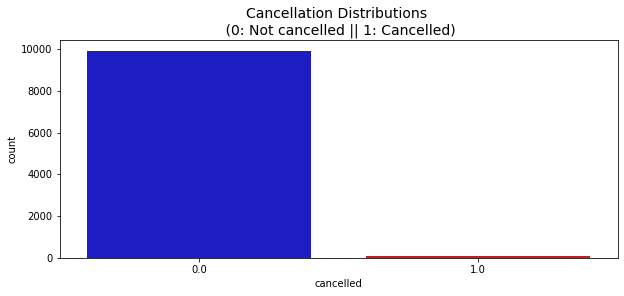

In [12]:
# Originial Data
f = plt.figure(figsize=(10,4))
colors = ["#0101DF", "#DF0101"]
sns.countplot('cancelled',data=X_cancel, palette=colors)
plt.title('Cancellation Distributions \n (0: Not cancelled || 1: Cancelled)', fontsize=14)
print ('The cancelling rate is',(X_cancel['cancelled']==1).sum()*100/X_cancel.shape[0],'% of the dataset')

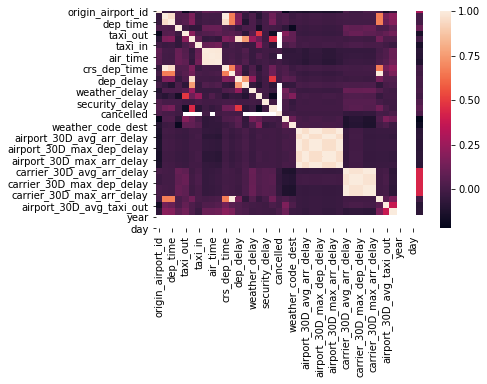

In [13]:
sns.heatmap(X_cancel.corr())

In [14]:
X=X_cancel[['year','month','day', 'origin_airport_id', 'dep_hr', 'arr_hr','carrier','crs_elapsed_time', 'distance','dest_airport_id','distance','airport_30D_avg_dep_delay', 'airport_30D_avg_arr_delay',
       'airport_30D_min_dep_delay', 'airport_30D_max_dep_delay',
       'airport_30D_min_arr_delay', 'airport_30D_max_arr_delay',
       'carrier_30D_avg_dep_delay', 'carrier_30D_avg_arr_delay',
       'carrier_30D_min_dep_delay', 'carrier_30D_max_dep_delay',
       'carrier_30D_min_arr_delay', 'carrier_30D_max_arr_delay', 'airport_30D_avg_taxi_out',
       'airport_30D_avg_taxi_in','weather_code_org','weather_code_dest']]
y=X_cancel['cancelled']

In [15]:
X.isnull().sum()

year                         0
month                        0
day                          0
origin_airport_id            0
dep_hr                       0
arr_hr                       0
carrier                      0
crs_elapsed_time             0
distance                     0
dest_airport_id              0
distance                     0
airport_30D_avg_dep_delay    0
airport_30D_avg_arr_delay    0
airport_30D_min_dep_delay    0
airport_30D_max_dep_delay    0
airport_30D_min_arr_delay    0
airport_30D_max_arr_delay    0
carrier_30D_avg_dep_delay    0
carrier_30D_avg_arr_delay    0
carrier_30D_min_dep_delay    0
carrier_30D_max_dep_delay    0
carrier_30D_min_arr_delay    0
carrier_30D_max_arr_delay    0
airport_30D_avg_taxi_out     0
airport_30D_avg_taxi_in      0
weather_code_org             0
weather_code_dest            0
dtype: int64

In [16]:
from sklearn.preprocessing import StandardScaler
scaller = StandardScaler()
X_std = pd.DataFrame(data=scaller.fit_transform(X),columns=X.columns)


In [17]:
X_train, X_test, y_train, y_test = train_test_split(X_std, y, test_size=0.3, random_state=42)

# UnderSampling

In [18]:
X_cancel_under = X_cancel.sample(frac=1)

cancelled_df = X_cancel_under.loc[X_cancel_under['cancelled'] == 1]
non_cancelled_df=X_cancel_under.loc[X_cancel_under['cancelled'] == 0][:cancelled_df.shape[0]]
normal_distributed_df = pd.concat([cancelled_df, non_cancelled_df])
under_sap_df = normal_distributed_df.sample(frac=1, random_state=42)
under_sap_df.head()

,origin_airport_id,dep_hr,op_unique_carrier,dep_time,dest_airport_id,taxi_out,arr_delay,taxi_in,distance,air_time,...,carrier_30D_max_dep_delay,carrier_30D_min_arr_delay,carrier_30D_max_arr_delay,arr_hr,airport_30D_avg_taxi_out,airport_30D_avg_taxi_in,year,month,day,carrier
1198,14771,6,WN,NaN,10800,NaN,NaN,NaN,326.0,NaN,...,-0.434783,0.173913,0.173913,7,21.857143,23.400000,2019,6,7,11
2113,13930,10,AA,NaN,11066,NaN,NaN,NaN,296.0,NaN,...,0.000000,0.000000,0.000000,12,9.000000,4.000000,2019,6,7,1
8737,11042,7,UA,811.0,14771,13.0,38.0,25.0,2161.0,274.0,...,10.791146,6.091989,6.091989,9,18.000000,17.500000,2019,6,7,10
29,13232,22,WN,10.0,10792,11.0,85.0,5.0,468.0,69.0,...,-0.434783,0.173913,0.173913,1,12.545455,11.142857,2019,6,7,11
4009,13342,6,DL,553.0,10397,13.0,0.0,13.0,669.0,96.0,...,0.000000,0.000000,0.000000,8,26.000000,0.000000,2019,6,7,3


The cancelling rate is 0.75 % of the undersampling dataset


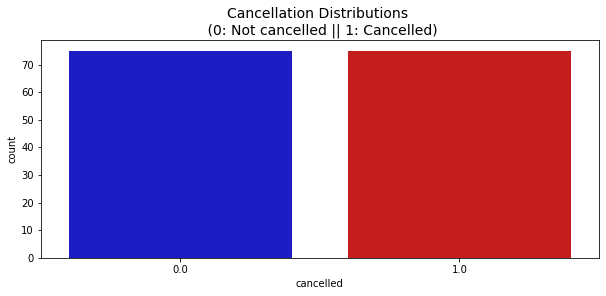

In [19]:
f = plt.figure(figsize=(10,4))
colors = ["#0101DF", "#DF0101"]
sns.countplot('cancelled',data=under_sap_df, palette=colors)
plt.title('Cancellation Distributions \n (0: Not cancelled || 1: Cancelled)', fontsize=14)
print ('The cancelling rate is',(X_cancel['cancelled']==1).sum()*100/X_cancel.shape[0],'% of the undersampling dataset')

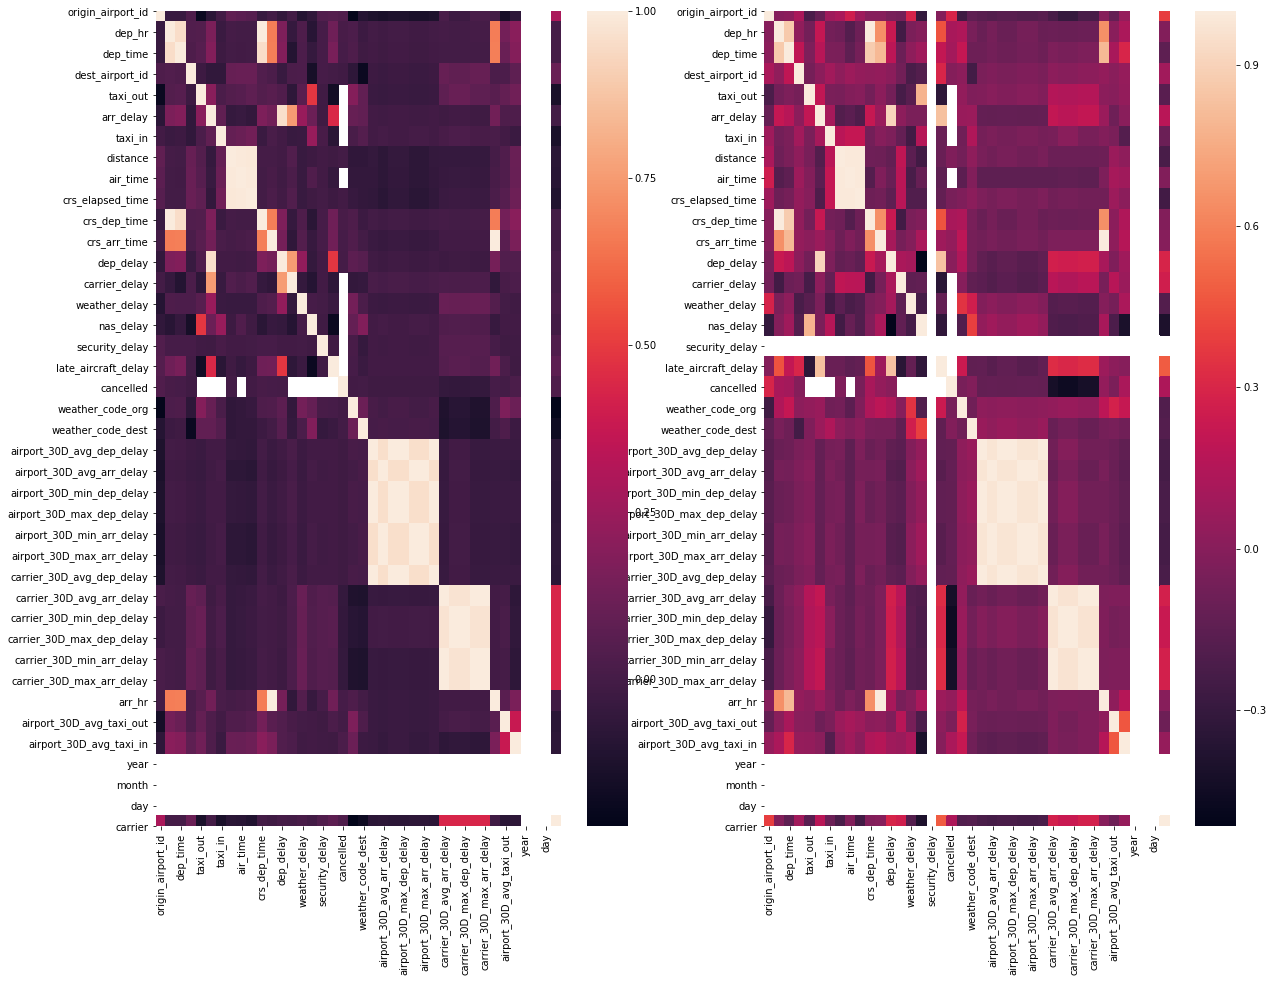

In [20]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,15))

sns.heatmap(X_cancel.corr(), annot_kws={'size':20}, ax=ax1)
sns.heatmap(under_sap_df.corr(),annot_kws={'size':20},ax=ax2)

In [21]:
# undersampling classifier

X_under=under_sap_df[X.columns]

y_under=under_sap_df['cancelled']

scaller = StandardScaler()
X_u_std = pd.DataFrame(data=scaller.fit_transform(X_under),columns=X_under.columns)
X_train_u, X_test_u, y_train_u, y_test_u = train_test_split(X_u_std, y_under, test_size=0.2, random_state=42)


# Random Oversampling

In [22]:
sm = SMOTE()
X_train_over,y_train_over = sm.fit_resample(X_train.values,y_train.values)

Class=0, n=6947 (69.470%)
Class=1, n=6947 (69.470%)


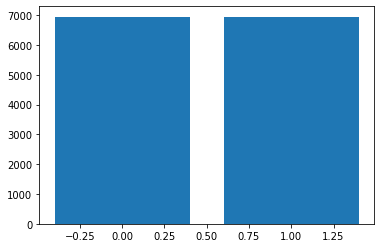

In [23]:
import matplotlib.pyplot as plt
from collections import Counter
counter = Counter(y_train_over)
for k,v in counter.items():
	per = v / len(y) * 100
	print('Class=%d, n=%d (%.3f%%)' % (k, v, per))
# plot the distribution
plt.bar(counter.keys(), counter.values())
plt.show()

# Choosing Classifer

## Original

In [24]:
# classfier compare function
def modelCompare(X_train,X_test,y_train,y_test):
    results_dict = {'Classifier':[],
                'Train Accuracy':[], 
                'Test Accuracy':[]
               }

    models = {
        'knn'           : KNeighborsClassifier(),
        'decision tree' : DecisionTreeClassifier(),
        'random forest' : RandomForestClassifier(n_estimators=10),
        'SVM'           : SVC(gamma='scale'),
        'logistic regression': LogisticRegression()
    }

    # Looping through models
    for model_name, model in models.items():
        print("Fitting %s..." % model_name)
        model.fit(X_train, y_train);
        train_accuracy = cross_val_score(model, X_train, y_train, cv=5).mean()*100
        test_accuracy = cross_val_score(model, X_test, y_test, cv=5).mean()*100
        results_dict['Classifier'].append(model_name)
        results_dict['Train Accuracy'].append(train_accuracy)
        results_dict['Test Accuracy'].append(test_accuracy)  
        
    results_df = pd.DataFrame(results_dict)

    return results_df

In [25]:
# Original 
modelCompare(X_train, X_test, y_train, y_test)

Fitting knn...
Fitting decision tree...
Fitting random forest...
Fitting SVM...
Fitting logistic regression...


,Classifier,Train Accuracy,Test Accuracy
0,knn,99.242857,99.266667
1,decision tree,98.371429,98.600000
2,random forest,99.200000,99.166667
3,SVM,99.242857,99.266667
4,logistic regression,99.242857,99.266667


In [26]:
from sklearn.metrics import recall_score

In [30]:
# KNN
knears_params = {"n_neighbors": list(range(5,7,1)), 'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']}

grid_knears = GridSearchCV(KNeighborsClassifier(), knears_params)
grid_knears.fit(X_train, y_train)
# KNears best estimator
knears_neighbors = grid_knears.best_estimator_
opt_knn_dt=knears_neighbors
opt_knn_dt.fit(X_train,y_train)
y_pred_knn_dt=opt_knn_dt.predict(X_test)
print(knears_neighbors)
print(Counter(y_pred_knn_dt))
print('Accurcy score for logistic model is',accuracy_score(y_test,y_pred_knn_dt))
print('Precision score for logistic model is',precision_score(y_test,y_pred_knn_dt))
print('Recall score for logistic model is',recall_score(y_test,y_pred_knn_dt))
print('ROC score for logistic model is',roc_auc_score(y_test,y_pred_knn_dt))
print('F1 score for logistic model is',f1_score(y_test,y_pred_knn_dt))

KNeighborsClassifier()
Counter({0.0: 3000})
Accurcy score for logistic model is 0.9926666666666667
Precision score for logistic model is 0.0
Recall score for logistic model is 0.0
ROC score for logistic model is 0.5
F1 score for logistic model is 0.0


In [35]:
# random forest
param_grid = {'n_estimators': list(range(10,20,1)),
               'max_depth': list(range(1,50,10)),
               'min_samples_leaf': list(range(5,7,1))}
rf = RandomForestClassifier(n_estimators=10)
rf_grid = GridSearchCV(rf,param_grid=param_grid)
rf_grid.fit(X_train,y_train)
rf_clf = rf_grid.best_estimator_
opt_rf=rf_clf
opt_rf.fit(X_train,y_train)
y_pred_rf=opt_rf.predict(X_test)
print(rf_clf)
print(Counter(y_pred_rf))
print('Accurcy score for logistic model is',accuracy_score(y_test,y_pred_rf))
print('Precision score for logistic model is',precision_score(y_test,y_pred_rf))
print('Recall score for logistic model is',recall_score(y_test,y_pred_rf))
print('ROC score for logistic model is',roc_auc_score(y_test,y_pred_rf))
print('F1 score for logistic model is',f1_score(y_test,y_pred_rf))

RandomForestClassifier(max_depth=1, min_samples_leaf=5, n_estimators=10)
Counter({0.0: 3000})
Accurcy score for logistic model is 0.9926666666666667
Precision score for logistic model is 0.0
Recall score for logistic model is 0.0
ROC score for logistic model is 0.5
F1 score for logistic model is 0.0


## Undersampling

In [36]:
modelCompare(X_train_u, X_test, y_train_u, y_test)

Fitting knn...
Fitting decision tree...
Fitting random forest...
Fitting SVM...
Fitting logistic regression...


,Classifier,Train Accuracy,Test Accuracy
0,knn,63.333333,99.266667
1,decision tree,75.000000,98.466667
2,random forest,78.333333,99.233333
3,SVM,64.166667,99.266667
4,logistic regression,64.166667,99.266667


In [32]:
# KNN
knears_params = {"n_neighbors": list(range(5,7,1)), 'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']}

grid_knears = GridSearchCV(KNeighborsClassifier(), knears_params)
grid_knears.fit(X_train_u, y_train_u)
# KNears best estimator
knears_neighbors_u = grid_knears.best_estimator_
opt_knn_u=knears_neighbors_u
opt_knn_u.fit(X_train_u, y_train_u)
y_pred_knn_u=opt_knn_dt.predict(X_test)
print(knears_neighbors_u)
print(Counter(y_pred_knn_u))
print('Accurcy score for logistic model is',accuracy_score(y_test,y_pred_knn_u))
print('Precision score for logistic model is',precision_score(y_test,y_pred_knn_u))
print('Recall score for logistic model is',recall_score(y_test,y_pred_knn_u))
print('ROC score for logistic model is',roc_auc_score(y_test,y_pred_knn_u))
print('F1 score for logistic model is',f1_score(y_test,y_pred_knn_u))

KNeighborsClassifier(n_neighbors=6)
Counter({0.0: 3000})
Accurcy score for logistic model is 0.9926666666666667
Precision score for logistic model is 0.0
Recall score for logistic model is 0.0
ROC score for logistic model is 0.5
F1 score for logistic model is 0.0


In [42]:
# random forest
param_grid = {'n_estimators': list(range(10,20,1)),
               'max_depth': list(range(1,50,10)),
               'min_samples_leaf': list(range(5,7,1))}
rf = RandomForestClassifier(n_estimators=10)
rf_grid = GridSearchCV(rf,param_grid=param_grid)
rf_grid.fit(X_train_u, y_train_u)
rf_clf_u = rf_grid.best_estimator_
opt_rf_under=rf_clf
opt_rf_under.fit(X_train_u,y_train_u)
y_pred_rf_under=opt_rf_under.predict(X_test)
print(rf_clf_u)
print(Counter(y_pred_rf_under))
print('Accurcy score for logistic model is',accuracy_score(y_test,y_pred_rf_under))
print('Precision score for logistic model is',precision_score(y_test,y_pred_rf_under))
print('Recall score for logistic model is',recall_score(y_test,y_pred_rf_under))
print('ROC score for logistic model is',roc_auc_score(y_test,y_pred_rf_under))
print('F1 score for logistic model is',f1_score(y_test,y_pred_rf_under))

RandomForestClassifier(max_depth=21, min_samples_leaf=6, n_estimators=16)
Counter({1.0: 2005, 0.0: 995})
Accurcy score for logistic model is 0.339
Precision score for logistic model is 0.010972568578553617
Recall score for logistic model is 1.0
ROC score for logistic model is 0.6670584284754869
F1 score for logistic model is 0.021706956092747906


## OverSampling

In [36]:
modelCompare(X_train_over,X_test, y_train_over, y_test)

Fitting knn...
Fitting decision tree...
Fitting random forest...
Fitting SVM...
Fitting logistic regression...


,Classifier,Train Accuracy,Test Accuracy
0,knn,98.503665,99.580000
1,decision tree,99.295673,99.133333
2,random forest,99.739830,99.533333
3,SVM,97.543481,99.560000
4,logistic regression,76.955584,99.480000


In [41]:
# KNN
knears_params = {"n_neighbors": list(range(10)), 'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']}

grid_knears = GridSearchCV(KNeighborsClassifier(), knears_params)
grid_knears.fit(X_train_over, y_train_over)
# KNears best estimator
knears_neighbors = grid_knears.best_estimator_
opt_knn_over=knears_neighbors
opt_knn_over.fit(X_train_over, y_train_over)
y_pred_knn_over=opt_knn_over.predict(X_test)
print(knears_neighbors)
print(Counter(y_pred_knn_over))
print('Accurcy score for logistic model is',accuracy_score(y_test,y_pred_knn_over))
print('Precision score for logistic model is',precision_score(y_test,y_pred_knn_over))
print('Recall score for logistic model is',recall_score(y_test,y_pred_knn_over))
print('ROC score for logistic model is',roc_auc_score(y_test,y_pred_knn_over))
print('F1 score for logistic model is',f1_score(y_test,y_pred_knn_over))

KNeighborsClassifier(n_neighbors=2)
Counter({0.0: 2945, 1.0: 55})
Accurcy score for logistic model is 0.9756666666666667
Precision score for logistic model is 0.03636363636363636
Recall score for logistic model is 0.09090909090909091
ROC score for logistic model is 0.5365559557970572
F1 score for logistic model is 0.05194805194805195


In [40]:
# random forest
param_grid = {'n_estimators': list(range(10,20,1)),
               'max_depth': list(range(1,50,10)),
               'min_samples_leaf': list(range(5,7,1))}
rf = RandomForestClassifier(n_estimators=10)
rf_grid = GridSearchCV(rf,param_grid=param_grid)
rf_grid.fit(X_train_over, y_train_over)
rf_clf_over = rf_grid.best_estimator_
opt_rf_over=rf_clf_over
opt_rf_over.fit(X_train_over, y_train_over)
y_pred_rf_over=opt_rf_over.predict(X_test)
print(rf_clf_over)
print(Counter(y_pred_rf_over))
print('Accurcy score for logistic model is',accuracy_score(y_test,y_pred_rf_over))
print('Precision score for logistic model is',precision_score(y_test,y_pred_rf_over))
print('Recall score for logistic model is',recall_score(y_test,y_pred_rf_over))
print('ROC score for logistic model is',roc_auc_score(y_test,y_pred_rf_over))
print('F1 score for logistic model is',f1_score(y_test,y_pred_rf_over))

RandomForestClassifier(max_depth=31, min_samples_leaf=5, n_estimators=19)
Counter({0.0: 2976, 1.0: 24})
Accurcy score for logistic model is 0.9853333333333333
Precision score for logistic model is 0.041666666666666664
Recall score for logistic model is 0.045454545454545456
ROC score for logistic model is 0.518865620611759
F1 score for logistic model is 0.043478260869565216
